In [1]:
import glob
import eigsep_observing.io as io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import os
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
import numpy as np
from hera_filters.dspec import dpss_operator, fit_solution_matrix
import h5py
import json

%matplotlib widget

In [2]:
def read_header(fname, keys=None):
    with h5py.File(fname, "r") as f:
        # header
        header_grp = f["header"]
        header = {k: v for k, v in header_grp.attrs.items() if keys is None or k in keys}
        for name, obj in header_grp.items():
            if keys is not None and name not in keys:
                continue
            if isinstance(obj, h5py.Group):
                header[name] = {k: v for k, v in obj.attrs.items()}
            else:
                header[name] = json.loads(obj[()])
    return header

mtn_tzone = ZoneInfo("America/Denver")

def unix_time_to_local(unix_times):
    local_times = np.array([datetime.fromtimestamp(ts, tz=timezone.utc).astimezone(mtn_tzone) for ts in unix_times])
    return local_times

/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_094242.h5 /home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250720_202334.h5


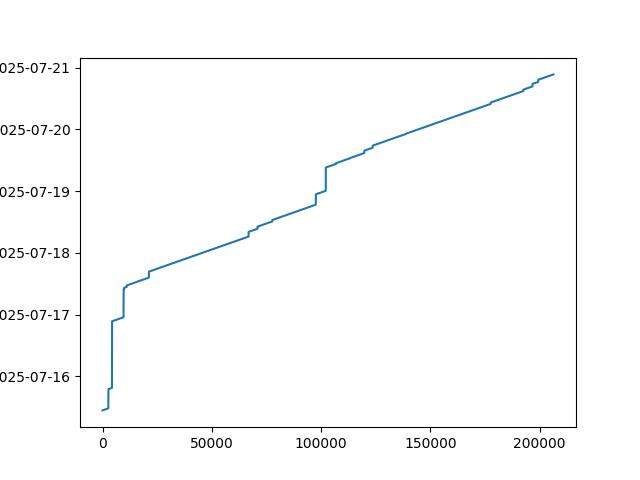

In [7]:
PATH = "/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data"
DATE_THRESH = 1735689600
if True:
    files = sorted(glob.glob(os.path.join(PATH, '*.h5')))
    print(files[0], files[-1])
    data = None
    while not data:
        try:
            data, hdr, meta = io.read_hdf5(files[0])
        except Exception:
            files.pop(0)
            data = None
        
    times = []
    acc_cnt = []
    for f in files:
        try:
            _hdr = read_header(f, {'times', 'acc_cnt'})
        except Exception:
            continue
        times.append(_hdr['times'])
        acc_cnt.append(_hdr['acc_cnt'])
    
    times = np.concatenate(times)
    t_valid = np.where(times > DATE_THRESH)
    times = times[t_valid]
    local_times = unix_time_to_local(times)
    freqs = hdr['freqs']
    plt.figure()
    plt.plot(local_times)

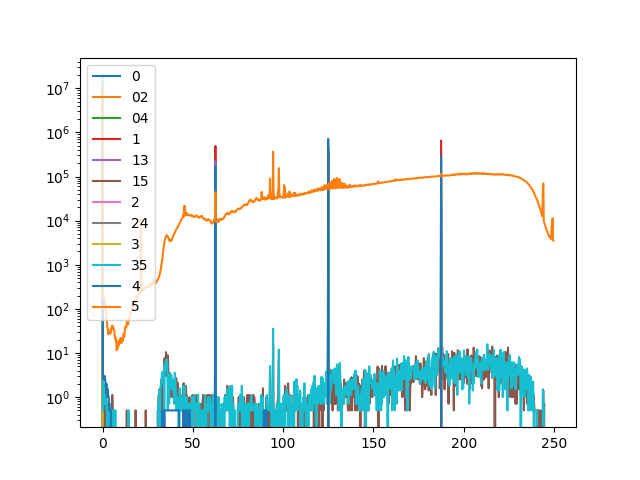

In [8]:
if True:
    plt.figure()
    for k, d in data.items():
        plt.semilogy(freqs, np.abs(d[0]), label=k)
    _ = plt.legend()

In [9]:
t_start = datetime(2025, 7, 20, 13, 11, 51, 774738, tzinfo=mtn_tzone)
t_stop =  datetime(2025, 7, 20, 14, 35, 41, 181442, tzinfo=mtn_tzone)

In [10]:
npz_file = 'marjum-2025-07_rotation.npz'
if not os.path.exists(npz_file):
    data = {}
    times = []
    for f in files:
        print(f)
        hdr = read_header(f)
        if unix_time_to_local(hdr['times'][-1:]) < t_start:
            continue
        if unix_time_to_local(hdr['times'][:1]) > t_stop:
            continue
        dat, hdr, meta = io.read_hdf5(f)
        times.append(hdr['times'])
        for k in dat.keys():
            _d = dat[k]
            data[k] = data.get(k, []) + [_d]
    for k, v in data.items():
        if len(k) == 1:
            dtype = np.float32
        else:
            dtype = np.complex64
        data[k] = np.concatenate(v, dtype=dtype)
    times = np.concatenate(times)
    local_times = unix_time_to_local(times)
    np.savez(npz_file, times=times, local_times=local_times, freqs=freqs, **data)
else:
    npz = np.load(npz_file, allow_pickle=True)
    data = {k: npz[k] for k in npz.files}
    times = data.pop('times')
    local_times = data.pop('local_times')
    freqs = data.pop('freqs')

/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_094746.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_095204.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_095622.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_100041.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_100459.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_100916.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_101335.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_101754.h5
/home/christian/Documents/research/eigsep/data-analysis/data/deployment4/corr_data/corr_20250715_102211.h5
/home/christian/Documents/research/ei

OSError: Unable to synchronously open file (bad object header version number)

KeyError: '2'

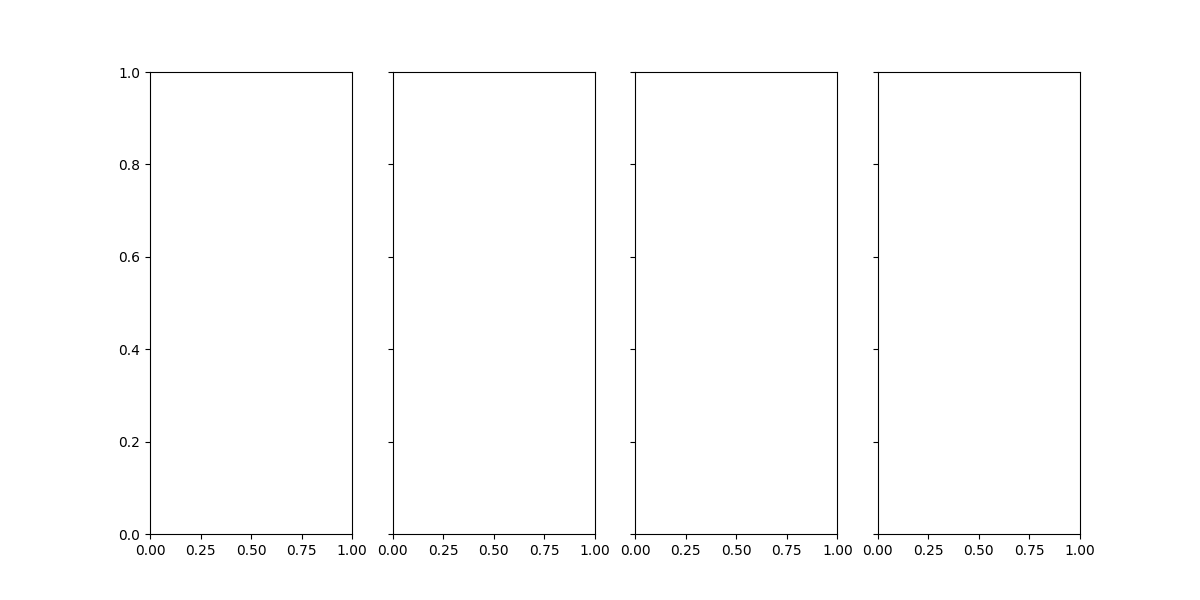

In [11]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 6), sharex=True, sharey=True)
k_1, k_2 = k12 = '24'
chs = np.arange(16, 1024, 16)
#vmax, vmin = 8, 5
vmax, vmin = 7, 4
#d1 = np.diff(data[k1], axis=0)
#d2 = np.diff(data[k2], axis=0)
#d12 = np.diff(data[k1+k2], axis=0)
d_1 = data[k_1][:,chs] - 0.5 * (data[k_1][:,chs-1] + data[k_1][:,chs+1])
d_2 = data[k_2][:,chs] - 0.5 * (data[k_2][:,chs-1] + data[k_2][:,chs+1])
d12 = data[k12][:,chs] - 0.5 * (data[k12][:,chs-1] + data[k12][:,chs+1])
modeR = lambda x: np.log10(np.abs(x))
modeC = lambda x: np.angle(x)
kwargsR = dict(vmax=8, vmin=5, aspect='auto', interpolation='nearest', cmap='plasma')
kwargsC = dict(aspect='auto', interpolation='nearest', cmap='bwr')
_ = axes[0].imshow(modeR(d_1), **kwargsR)
_ = axes[1].imshow(modeC(d12), **kwargsC)
_ = axes[2].imshow(modeR(d12), **kwargsR)
_ = axes[3].imshow(modeR(d_2), **kwargsR)

On this particular run, we can check the phase of the cross-correlation before and after and verify that they are the same.
This implies that the platform and antenna were quite stable 

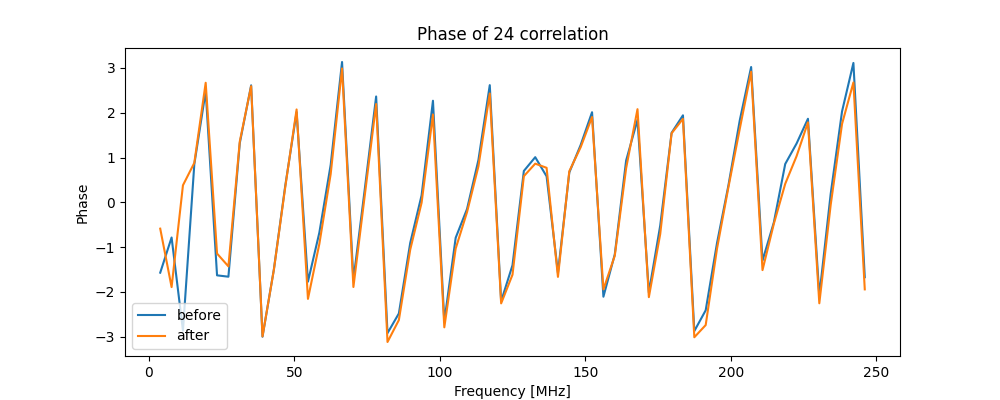

In [8]:
plt.figure(figsize=(10,4))
plt.title(f'Phase of {k12} correlation')
plt.plot(freqs[chs], np.angle(d12[ 0]), label='before')
plt.plot(freqs[chs], np.angle(d12[-1]), label='after')
plt.ylabel('Phase')
plt.xlabel('Frequency [MHz]')
_ = plt.legend()

In [9]:
#fm_chs = np.logical_and(freqs <= 110, freqs >= 88)
#ch = 368
#d1 = data[k1][:, ch] - 0.5 * (data[k1][:, ch+1] + data[k1][:, ch-1])
#d2 = data[k2][:, ch] - 0.5 * (data[k2][:, ch+1] + data[k2][:, ch-1])
#d12 = data[k12][:, ch] - 0.5 * (data[k12][:, ch+1] + data[k12][:, ch-1])
#plt.figure()
#_ = plt.plot(times - 1753039000, d1 / 1e7)
#_ = plt.plot(times - 1753039000, d2 / 1e7)
#_ = plt.plot(times - 1753039000, np.real(d12) / 1e7)
#_ = plt.plot(times - 1753039000, np.unwrap(np.angle(d12)))

In [10]:
#t_starts = [datetime(2025, 7, 19,  9, 12, 57, 506294, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 13,  4,  2, 734467, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 14, 17, 40, 108331, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 16, 44, 48, 149913, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 17, 58, 13, 363386, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 19, 11, 57, 179701, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 20, 25, 19, 521180, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 21, 39,  5, 484978, tzinfo=mtn_tzone),
#            datetime(2025, 7, 19, 22, 52, 30, 692350, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  0,  6, 19, 877374, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  1, 19, 36, 850143, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  2, 33, 28, 182651, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  3, 46, 41, 934195, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  5,  0, 36, 487928, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  6, 13, 47,  18246, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  7, 27, 44, 793205, tzinfo=mtn_tzone),
#            datetime(2025, 7, 20,  8, 40, 51,  28556, tzinfo=mtn_tzone),]
##t_starts = [t_starts[0] - delta_date] + t_starts
#inds = np.array([np.searchsorted(local_times, t_start) for t_start in t_starts])
#print(inds)
#print(local_times[inds])

In [12]:
#plt.figure()
#plt.semilogy(np.fft.fftfreq(d12.shape[0], np.median(np.diff(times))), np.abs(np.fft.fft(d12[:,33])))

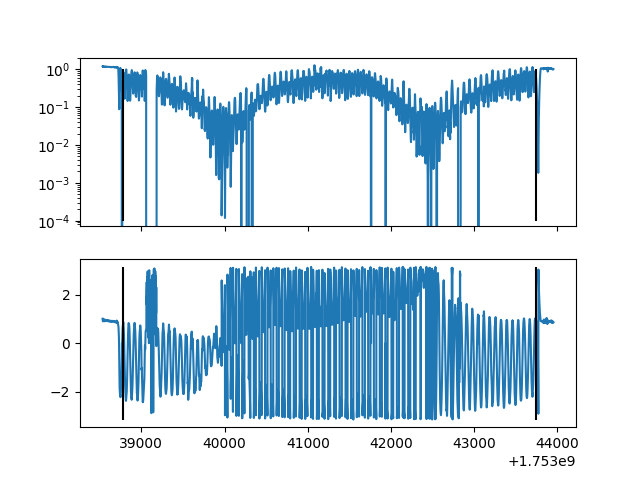

In [13]:
AZ_STEPS = 72  # with endpoint=True
period = 68.78
#t_start = 1753038750 # s utc
t_start = 1753038750 + period/2 # s utc
t_cut = [(1753039060, 1753039181), (1753042808, 1753042834)]  # junk data
i_start = np.searchsorted(times, t_start)
norm = 1 / np.mean(d_1[:i_start], axis=0, keepdims=True)
norm[:,:4] = 0
t_stop = t_start + AZ_STEPS * period
i_stop = np.searchsorted(times, t_stop)
#period = 5100 / AZ_STEPS
#period = 68.80 * 2
#print(period)
##t_off = 543
#t_off = 543 + 64 + 64
#sl = slice(-20000+t_off+7, -14000-780)
#_times = times[sl] - times[-20000+t_off]
valid = np.ones(times.shape, dtype=bool)
valid = np.where(d_1[:,33] * norm[:,33] < 1e-4, False, ~np.isnan(d_1[:,33]))
for ti, tj in t_cut:
    i, j = np.searchsorted(times, ti), np.searchsorted(times, tj)
    valid[i:j] = False
#valid[188:288] = False
#valid[3675:3698] = False
valid[1:-1] = np.logical_and(valid[1:-1], np.logical_and(valid[:-2], valid[2:]))

fig, axes = plt.subplots(nrows=2, sharex=True)
#_ = plt.semilogy(local_times[sl], data[ANT][:,33][sl])
_ = axes[0].semilogy(times, d_1[:,33] * norm[:,33] * valid)
_ = axes[0].vlines([t_start, t_stop], ymax=1e0, ymin=1e-4, color='k')
#_ = axes[0].semilogy(times-68.78, d_1[:,33])
_ = axes[1].plot(times, np.angle(d12[:,33]))
_ = axes[1].vlines([t_start, t_stop], ymax=np.pi, ymin=-np.pi, color='k')
#_ = axes[1].plot(times-68.78, np.angle(d12[:,33]))

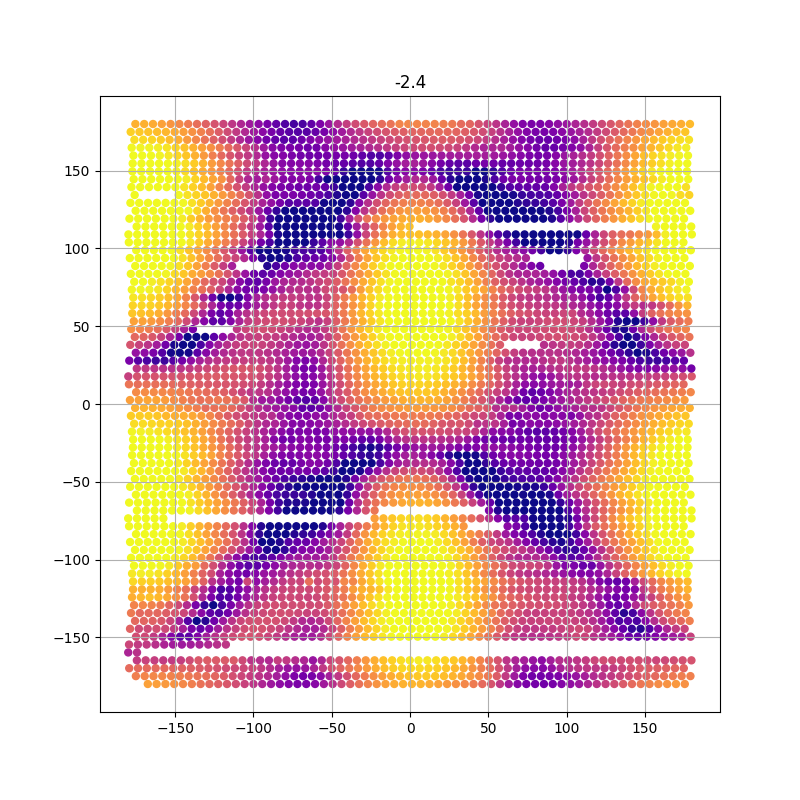

In [14]:
sl = slice(i_start, i_stop)
_times = times[sl].copy()
_times -= _times[0]
_times_rnd = np.floor(_times / (2 * period))
_times_mod = _times - _times_rnd * (2 * period)
val = valid[sl]

ch = 44
#plt.figure(figsize=(8,4))
##_ = plt.semilogy(local_times[sl], data[ANT][:,ch][sl])
##_ = plt.semilogy(d_1[:,ch][sl] * valid)
#_ = plt.scatter(_times_mod[val]-period, _times_rnd[val], c=np.log10(d_1[:,ch][sl][val] * norm[:,ch]), s=18, cmap='plasma', vmax=0.5, vmin=-1.5)

if True:
    t_off = -2.4
    az, el = [], []
    i = 0
    t_i = _times[0] + t_off

    inds = []
    for cnt, _az in enumerate(np.linspace(-180, 180, AZ_STEPS, endpoint=True)):
        t_f = t_i + period
        while i < len(_times) and _times[i] < t_f:
            az.append(_az)
            if cnt % 2 == 0:
                el.append(-180 + 360 * (_times[i] - t_i) / period)
            else:
                el.append( 180 - 360 * (_times[i] - t_i) / period)
            inds.append(i)
            i += 1
        t_i = t_f
    az = np.array(az)
    el = np.array(el)
            
    ch = 44
    plt.figure(figsize=(8,8))
    _ = plt.scatter(el[val[inds]], az[val[inds]], c=np.log10(d_1[:,ch][sl][inds][val[inds]] * norm[:,ch]), s=25, cmap='plasma', vmax=0.5, vmin=-1.5)
    _ = plt.grid()
    _ = plt.title(t_off)

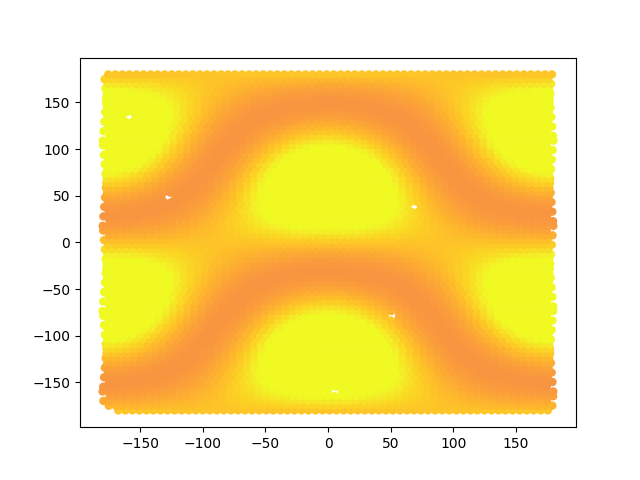

In [85]:
import aipy
import healpy

dtype_r = np.float32
dtype_c = np.complex64
SQRT2 = np.sqrt(2.0)
gnd_pol_vec = np.dot(aipy.coord.rot_m(np.deg2rad(60), np.array([0, 0, 1])), np.array([1, 0, 0]))

def gen_pol_resp(az_deg, el_deg, gnd_pvec):
    el_ax = np.array([1, 0, 0], dtype=dtype_r)
    ant_pvec = el_ax
    az_ax = np.array([0, 0, 1], dtype=dtype_r)
    rot_az = aipy.coord.rot_m(np.deg2rad(az_deg), az_ax)
    rot_el = aipy.coord.rot_m(np.deg2rad(el_deg), el_ax)
    ant_pvec_rot = np.einsum('pab,pbc,c->pa', rot_el, rot_az, ant_pvec)
    resp = np.dot(ant_pvec_rot, gnd_pvec)
    return np.abs(resp)**2

plt.figure()
_ = plt.scatter(el, az, c=gen_pol_resp(az, el, gnd_pol_vec), s=25, cmap='plasma', vmax=0.5, vmin=-1.5)

In [86]:
import healpy as hp
from healpy.sphtfunc import Alm
from scipy.special import sph_harm


def A_matrix_real_sph(az_deg, el_deg, lmax):
    assert az_deg.shape == el_deg.shape
    
    phi = np.deg2rad(az_deg)
    theta = np.deg2rad(el_deg)
    theta = np.mod(theta, 2*np.pi)
    theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
    phi = np.mod(phi, 2*np.pi)
    pol_resp = gen_pol_resp(az_deg, el_deg, gnd_pol_vec)

    N = theta.size
    M = (lmax + 1)**2
    A = np.empty((N, M), dtype=np.float32)

    # Keep track of which column corresponds to which (l,m,kind)
    # kind ∈ {'m0','c','s'} for m=0, cos-like, sin-like
    meta = []
    col = 0
    for ell in range(lmax + 1):
        # m = 0 term (purely real)
        Y_l0 = sph_harm(0, ell, phi, theta).real
        Y_l0 *= gen_pol_resp(az_deg, el_deg, gnd_pol_vec)
        A[:, col] = Y_l0
        meta.append((ell, 0, 'm0'))
        col += 1

        # m > 0 terms: sqrt(2)*Re and sqrt(2)*Im
        for m in range(1, ell + 1):
            Y_lm = sph_harm(m, ell, phi, theta)  # complex
            Y_lm *= np.cos(phi)**2  # polarization response
            A[:, col] = SQRT2 * Y_lm.real
            A[:, col+1] = SQRT2 * Y_lm.imag
            meta.append((ell, m, 'c'))
            meta.append((ell, m, 's'))
            col += 2

    assert col == M
    return A, meta


def _realcoef_to_alm(coef, meta, lmax, dtype=np.complex64):
    """
    Convert real-basis coefficients (matching design-matrix columns) into a
    healpy alm array (complex, m>=0). For a real sky, alms obey:
      a_{l,-m} = (-1)^m a_{l m}^*
    We only fill m>=0 as healpy expects.
    """
    alm = np.zeros(Alm.getsize(lmax), dtype=dtype)

    # We reconstruct a_{l0} directly, and for m>0:
    # let columns be c = sqrt(2) Re(Y_lm), s = sqrt(2) Im(Y_lm).
    # Then a_{lm} = (c - i s) / sqrt(2).
    # (Derivation: matching the real-harmonic expansion to 2 Re[a Y].)
    for k, (ell, m, kind) in enumerate(meta):
        if m == 0 and kind == 'm0':
            alm[Alm.getidx(lmax, ell, 0)] = float(coef[k])  # real number
        elif kind in ('c', 's'):
            # we need both c and s for this (ell, m)
            # find their positions
            # (we know meta is structured m0, then for each m>0: 'c', 's')
            # so current k could be 'c' or 's'; grab sibling via +/-1.
            if kind == 'c':
                c = coef[k]
                s = coef[k + 1]
            else:  # kind == 's'
                c = coef[k - 1]
                s = coef[k]
            a_lm = (c - 1j * s) / SQRT2
            alm[Alm.getidx(lmax, ell, m)] = a_lm
    return alm


def fit_alm_from_points(az_deg, el_deg, ymeas, lmax, w=None, reg=None, rcond=1e-10):
    # Build design matrix in a real basis
    A, meta = A_matrix_real_sph(az_deg, el_deg, lmax)

    # Apply weights (as sqrt weights on rows)
    if w is None:
        w = np.ones_like(ymeas)
    sqrtw = np.sqrt(w)
    Aw = A * sqrtw[:, None]
    yw = ymeas * sqrtw

    # Optional ridge regularization: stack sqrt(reg)*I
    if reg is not None and reg > 0:
        M = A.shape[1]
        Aw = np.vstack([Aw, np.sqrt(reg) * np.eye(M)])
        yw = np.concatenate([yw, np.zeros(M)])

    # Solve the real least-squares system
    coef = np.linalg.lstsq(Aw, yw, rcond=rcond)[0]

    # Predictions and chi^2
    yhat = A @ coef
    chisq = float(np.sum(w * (ymeas - yhat)**2))

    # Convert to healpy alm array (complex, m>=0)
    alm = _realcoef_to_alm(coef, meta, lmax)
    return alm, chisq, yhat

/tmp/ipykernel_266545/2269505717.py:26: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_l0 = sph_harm(0, ell, phi, theta).real
/tmp/ipykernel_266545/2269505717.py:34: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_lm = sph_harm(m, ell, phi, theta)  # complex
/tmp/ipykernel_266545/522519177.py:17: RuntimeWarning: invalid value encountered in log10
  _ = axes[2].scatter(el[val[inds]], az[val[inds]], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)


chi^2 = 353.9838562011719


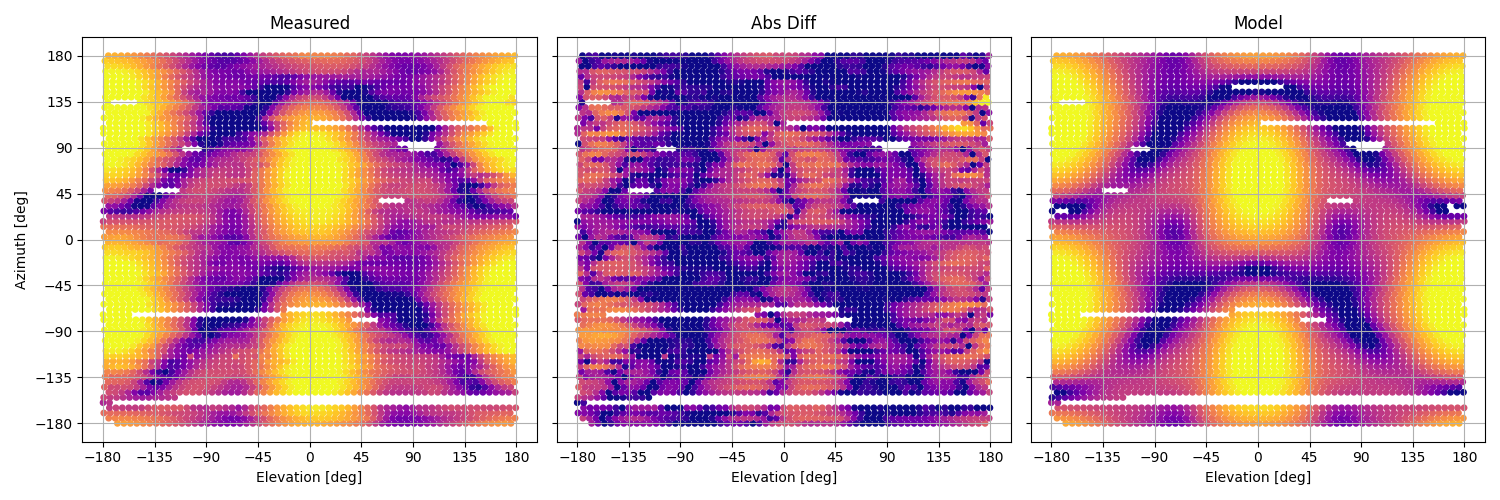

In [94]:
ymeas = d_1[:,ch][sl][inds][val[inds]] * norm[:,ch]

alm_fit, chisq, yhat = fit_alm_from_points(az[val[inds]], el[val[inds]], ymeas, lmax=5)

# Now alm_fit can be used with healpy, e.g. to make a map:
#   nside = 64
#   m = hp.alm2map(alm_fit, nside, lmax=3)
# or to compare alm_fit vs alm_true numerically.
print("chi^2 =", chisq)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
#_ = axes[0].scatter(theta, phi, c=np.log10(ymeas),              s=5, cmap='plasma', vmax=0.5, vmin=-1.5)
#_ = axes[1].scatter(theta, phi, c=np.log10(np.abs(ymeas-yhat)), s=5, cmap='plasma', vmax=0.5, vmin=-1.5)
#_ = axes[2].scatter(theta, phi, c=np.log10(yhat),               s=5, cmap='plasma', vmax=0.5, vmin=-1.5)
s = 15
_ = axes[0].scatter(el[val[inds]], az[val[inds]], c=np.log10(ymeas), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
_ = axes[1].scatter(el[val[inds]], az[val[inds]], c=np.log10(np.abs(ymeas-yhat)), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
_ = axes[2].scatter(el[val[inds]], az[val[inds]], c=np.log10(yhat), s=s, cmap='plasma', vmax=0.5, vmin=-1.5)
axes[0].set_ylabel('Azimuth [deg]')
for ax in axes:
    ax.set_xticks(np.linspace(-180, 180, 9))
    ax.set_yticks(np.linspace(-180, 180, 9))
    ax.grid()
    ax.set_xlabel('Elevation [deg]')
_ = axes[0].set_title('Measured')
_ = axes[1].set_title('Abs Diff')
_ = axes[2].set_title('Model')
_ = plt.tight_layout()

In [10]:
local_times[sl][0], local_times[sl][-1]

(datetime.datetime(2025, 7, 20, 13, 14, 19, 951110, tzinfo=zoneinfo.ZoneInfo(key='America/Denver')),
 datetime.datetime(2025, 7, 20, 14, 35, 41, 181442, tzinfo=zoneinfo.ZoneInfo(key='America/Denver')))